# ME462/597 - Lab 2 - Task 2
## Implementing a massively-parallel array of PID controllers on a GPU for use in process control

In [1]:
import os
import numpy as np
import math
from numba import cuda
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [3]:
def square_wave(k, dt, waveparams):
  """Generates a list of square waves.

  As a bonus, try to generate random square waves.
  """
  # return np.array([a*signal.square(2 * np.pi * k * dt - p) for a, f, p in zip(waveparams['amplitude'], waveparams['frequency'], waveparams['phase'])])
  return np.array(len(waveparams['amplitude'])*[signal.square(0.1 * 2 * np.pi * k * dt)])

def shift_cols(new_col, matrix):
  """Replaces first column and shifts remaining columns to the right."""

  return np.hstack([new_col.reshape((len(new_col), 1)), matrix[:,:-1]])

def compute_error(x_l, r_l, Nsamples=5):
  err = np.asarray(x_l) - np.asarray(r_l)
  print("Total squared error:", np.linalg.norm(err.flatten()))
  print("Mean squared error:", np.linalg.norm(err.flatten())/np.prod(err.shape))

  for idx, i in enumerate(sorted((np.random.random(Nsamples)*err.shape[0]).astype(int))):
    plt.plot(np.asarray(x_l)[:,i], color=plt.cm.tab10(idx), label=f'State {i}')
    plt.plot(np.asarray(r_l)[:,i], color=plt.cm.tab10(idx), linestyle=':', label=f'Reference {i}')

  plt.xlabel('Sample index')
  plt.ylabel('Signal')
  plt.legend()
  plt.show()


def propagate_model(X, U):
  """Propages the state of a discretized beam using a zero-order hold transfer
  function.

  Inputs:
    X is an n x 2 matrix
    U is an n x 1 matrix

    If the current time is k, the i-th column of each matrix corresponds to the
    state or control input at time instant k + 1 - i
    (i.e., from current to old).

  Output:
    Updated X as an n x 3 matrix; Shift the columns of X by one to the right,
    and add the current state as simulated using a zero-order hold transfer
    function.

  Bonus points:
    Implement this function on the GPU using the @cuda.jit decorator.
  """

  Xnew = np.zeros(X.shape)
  # x = np.zeros(X.shape[0])
  # YOUR CODE HERE.
  # Your code will produce Xnew in terms of your transfer function's
  # coefficients ai and bi.
  # Coefficients ai and bi are obtained from your z-domain transfer function.
  # The coefficients currently provided are based on the transfer function given
  # in the lab assignment, sampled at 0.1 seconds.
  x = (1.57*X[:,0] - X[:,1] + 0.1058 * U[:,0] + 0.1548 * U[:,1])/0.8623
  # print(x)
  # print(0)

  Xnew = shift_cols(x, X)

  return Xnew

@cuda.jit
def pid(x, r, K, dt, x_old, I_old, u):
  """Strided PID kernel for CUDA."""
  s1 = cuda.grid(1)
  d1 = cuda.gridsize(1)

  for i1 in range(s1, len(x), d1):
    # Proportional
    u[i1] = K[i1, 0] * (r[i1] - x[i1])

    # Integral
    # Add an integral term
    # YOUR CODE HERE.
    I_old[i1] += (x[i1]-x_old[i1])*dt[i1]
    u[i1] += K[i1,1]*I_old[i1]

    # Derivative
    u[i1] += K[i1, 2] * (x[i1] - x_old[i1])/dt[i1]

    # Update x
    x_old[i1] = x[i1]

def generateInitParams(Ninstances, Nhorizon):
  params = {
      'Ninstances' : Ninstances,
      'Nhorizon' : Nhorizon,
      'x' : np.random.random(Ninstances)*0.1,
      # 'x' : np.zeros(Ninstances),
      'waveparams' : {
        'amplitude' : np.random.random(Ninstances)*1.5,
        'frequency' : 0.05 + np.random.random(Ninstances)*1,
        'phase'     : np.random.random(Ninstances)*0.5,
      }
  }

  return params

def main(params):
  """"""
  # Problem parameters
  Ninstances = params['Ninstances']
  Nhorizon = params['Nhorizon']

  # The following parameters follow from the discretized TF:
  Nx = 2 # Number of states x(k-1), ..., x(k-Nx+1)
  Nu = 2 # Number of inputs u(k), ..., u(k-Nu+1)
  h = 0.1

  # Simulation parameters.
  dt = np.ascontiguousarray(h*np.ones(Ninstances))
  x = np.ascontiguousarray(params['x'])
  x_old = np.ascontiguousarray(np.zeros(Ninstances))
  u = np.ascontiguousarray(np.zeros(Ninstances))

  I_old = np.ascontiguousarray(np.zeros(Ninstances))

  # Tune this:
  K = np.ascontiguousarray(np.vstack(Ninstances*[np.asarray([[1e-2,1e-3,0]])]))

  # Initialize static GPU data.
  d_dt = cuda.to_device(dt)
  d_K = cuda.to_device(K)

  X = np.ascontiguousarray(np.hstack([x.reshape((-1, 1)), np.zeros((Ninstances, Nx - 1))]))
  U = np.ascontiguousarray(np.zeros((Ninstances, Nu)))

  # Fetch waveparams.
  waveparams = params['waveparams']

  r_l = [square_wave(0, h, waveparams)]
  x_l = [np.copy(x)]
  u_l = [u]

  for k in range(Nhorizon):
    r = square_wave(k, h, waveparams)
    r_l.append(np.copy(r))

    d_x = cuda.to_device(x)
    d_x_old = cuda.to_device(x_old)
    d_r = cuda.to_device(r)
    d_u = cuda.to_device(u)
    d_I_old = cuda.to_device(I_old)

    pid[Ninstances,256](d_x, d_r, d_K, d_dt, d_x_old, d_I_old, d_u)

    x_old = np.copy(x)
    u = np.ascontiguousarray(d_u.copy_to_host())

    I_old = np.ascontiguousarray(d_x_old.copy_to_host())

    u_l.append(np.copy(u))


    U = np.ascontiguousarray(shift_cols(u, U))
    X = np.ascontiguousarray(propagate_model(X, U))
    x = np.ascontiguousarray(X[:,0])

    x_l.append(np.copy(x))


  compute_error(x_l, u_l)


  return (x_l, u_l, r_l, h*np.arange(Nhorizon))

Total squared error: 10300.059876576288
Mean squared error: 0.10198079085719097


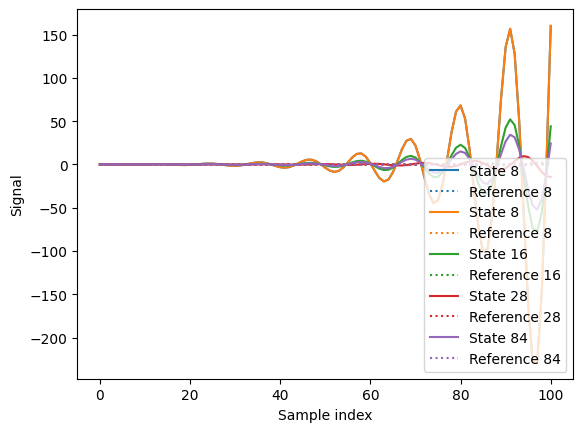

In [4]:
x, u, r, t = main(generateInitParams(1000, 100))
print()

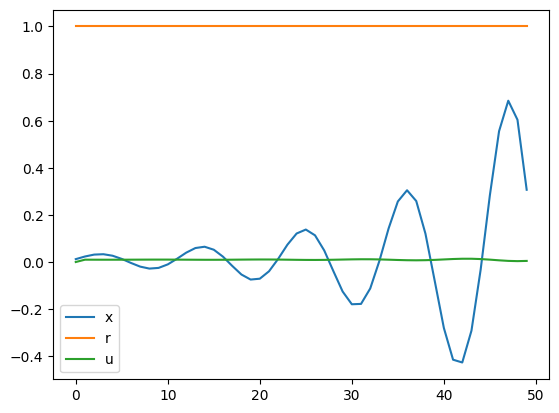

In [5]:
idx = 0
hor = 50

plt.plot(np.asarray(x)[:hor,idx], label='x')
plt.plot(np.asarray(r)[:hor,idx], label='r')
plt.plot(np.asarray(u)[:hor,idx], label='u')
plt.legend()